# Bootstrap Aggregation

In [263]:
import warnings
warnings.filterwarnings('ignore')

In [369]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

from sklearn.utils import resample

In [370]:
os.chdir('/Users/Dippies/CODE PACKT - EML/Chapter 5')
os.getcwd()

'/Users/Dippies/CODE PACKT - EML/Chapter 5'

In [371]:
# Let's read our data. We prefix the data frame name with "df_" for easier understanding.
df_autodata = pd.read_csv("autompg.csv")

In [372]:
# The below syntax returns the column names which has any missing value
columns_with_missing_values=df_autodata.columns[df_autodata.isnull().any()]

# We pass the column names with missing values to the datafram to count the number
# of missing values
df_autodata[columns_with_missing_values].isnull().sum()

horsepower    6
dtype: int64

In [ ]:
df_autodata['horsepower'].fillna(df_autodata['horsepower'].median(), inplace=True)
df_autodata.drop(['carname'], axis=1, inplace=True)

In [267]:
df_autodata.shape

(398, 8)

In [268]:
columns_with_missing_values=df_autodata.columns[df_autodata.isnull().any()]
df_autodata[columns_with_missing_values].isnull().sum()

Series([], dtype: float64)

In [269]:
df_autodata.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
0,18.0,8,307.0,130.0,3504,12.0,70,1
1,15.0,8,350.0,165.0,3693,11.5,70,1
2,18.0,8,318.0,150.0,3436,11.0,70,1
3,16.0,8,304.0,150.0,3433,12.0,70,1
4,17.0,8,302.0,140.0,3449,10.5,70,1


## Create Bootstrap Samples

In [270]:
def create_bootstrap_oob(df):
    global df_OOB
    global df_bootstrap_sample  
    
    # creating the bootstrap sample
    df_bootstrap_sample = resample(df, replace=True, n_samples=100)
    
    # creating the OOB sample    
    bootstrap_sample_index = tuple(df_bootstrap_sample.index)
    bootstrap_df = df.index.isin(bootstrap_sample_index)
    df_OOB = df[~bootstrap_df]

In [271]:
iteration=50
bootstap_statistics=list()
originalsample_statistics=list()

for i in range(iteration):
    # call custom function create_bootstrap_oob(). Pass df_autodata
    create_bootstrap_oob(df_autodata)
    
    # capture mean value of mpg variable for all bootstrap samples
    bootstap_statistics.append(df_bootstrap_sample.iloc[:,0].mean())
    
    originalsample_statistics.append(df_autodata['mpg'].mean())

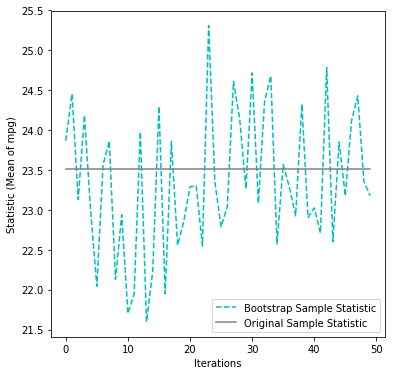

In [272]:
import matplotlib.pyplot as plt
f, ax= plt.subplots(figsize=(6,6))

plt.plot(bootstap_statistics, 'c--', label='Bootstrap Sample Statistic')
plt.plot(originalsample_statistics, 'grey', label='Original Sample Statistic')
plt.xlabel('Iterations')
plt.ylabel('Statistic (Mean of mpg)')
plt.legend(loc=4)
plt.show()

## Build models on bootstrap samples

In [273]:
iteration=50
mse_each_iterations = list()
lm=SGDRegressor()
total_mse=0
average_mse= list()

for i in range(iteration):
    create_bootstrap_oob(df_autodata)
    X_BS = df_bootstrap_sample.iloc[:,1:8] #Bootstrap sample features
    Y_BS = df_bootstrap_sample.iloc[:,0] #Bootstrap sample response variable

    X_OOB = df_OOB.iloc[:,1:8] #OOB sample features
    Y_OOB = df_OOB.iloc[:,0] #OOB sample response variable    
    
    # fit your model with bootstrap sample
    lm=SGDRegressor()
    lm.fit(X_BS, Y_BS)
    
    # test your model on out-of-bag sample 
    predictedvalues = lm.predict(X_OOB)
    
    # capture MSE for the predicted values against OOB actuals
    mse = mean_squared_error(Y_OOB, predictedvalues)
    
    # create a list of mse values
    mse_each_iterations.append(mse) 

    # add all mse for calculating average
    total_mse += mse
    average_mse.append(total_mse/i)


## Evaluate models built on Bootstrap samples

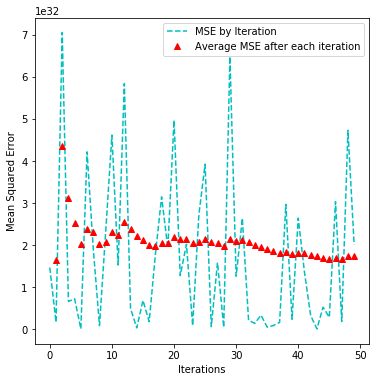

In [274]:
import matplotlib.pyplot as plt
f, ax= plt.subplots(figsize=(6,6))

plt.plot(mse_each_iterations, 'c--', label='MSE by Iteration')
plt.plot(average_mse, 'r^', label='Average MSE after each iteration')

plt.xlabel('Iterations')
plt.ylabel('Mean Squared Error')
plt.legend(loc=1)
plt.show()

## Bagging Classifier
### Using BaggingClassifier on Decision Tree model on Wine Data

In [478]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

In [479]:
df_winedata = pd.read_csv('winedata.csv')
df_winedata.shape

(177, 14)

In [519]:
X = df_winedata.iloc[:,1:14]
Y = df_winedata.iloc[:,0]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=1)

In [481]:
dt_model = DecisionTreeClassifier(criterion='entropy')
bag_dt_model = BaggingClassifier(dt_model, max_features=1.0, n_estimators=5, \
                                 random_state=1, bootstrap=True)

In [482]:
bag_dt_model.fit(X_train, Y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=5, n_jobs=1, oob_score=False,
         random_state=1, verbose=0, warm_start=False)

In [483]:
bag_dt_model.score(X_test, Y_test)

0.91111111111111109

In [484]:
predictedvalues = bag_dt_model.predict(X_test)

In [485]:
# code from 
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actuals')
    plt.xlabel('Predicted')

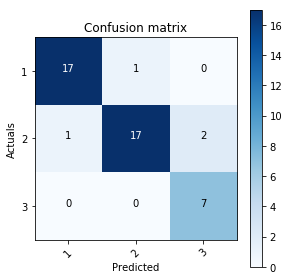

In [486]:
target_names = [ '1', '2', '3']

# Formulating the Confusion Matrix
import itertools
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(Y_test, predictedvalues)

plt.figure(figsize=(4,4))
plot_confusion_matrix(cm, classes=target_names, normalize=False)
plt.show()

### Using grid search & multiple classifier on Wine Data

In [487]:
from sklearn.model_selection import GridSearchCV

param_values = {'n_estimators': [10, 20, 25, 30], 'base_estimator__max_leaf_nodes':[5, 10, 15, 20], 'base_estimator__max_depth':[3, 4, 5]}

dt_model = DecisionTreeClassifier()
bag_dt_model_grid = BaggingClassifier(base_estimator=dt_model, oob_score=True, bootstrap=True, random_state=1) 

# Use GridSearchCV() to determine best parameters
bc_grid = GridSearchCV(estimator=bag_dt_model_grid, param_grid=param_values, cv=20, n_jobs=-1)
bc_grid.fit(X_train, Y_train)
best_params = bc_grid.best_params_
print(best_params)

{'base_estimator__max_depth': 3, 'base_estimator__max_leaf_nodes': 10, 'n_estimators': 20}


In [505]:
best_dt_model = DecisionTreeClassifier(criterion='entropy', max_leaf_nodes=10, max_depth=3)                   
final_bag_dt_model = BaggingClassifier(base_estimator=best_dt_model, n_estimators=150, bootstrap=True, random_state=1, oob_score=True)

In [506]:
final_bag_dt_model.fit(X_train, Y_train)
bag_predictedvalues = final_bag_dt_model.predict(X_test)

# compare OOB accuracy to test-set accuracy
acc_oob = final_bag_dt_model.oob_score_
print(acc_oob)  

0.954545454545


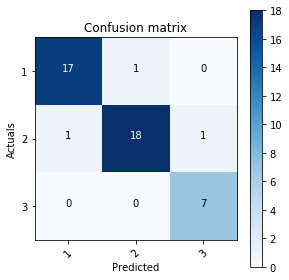

In [498]:
cm = confusion_matrix(Y_test, bag_predictedvalues)

plt.figure(figsize=(4,4))
plot_confusion_matrix(cm, classes=target_names, normalize=False)
plt.show()

## Bagging Regressor
### Using Decision Tree Regressor on Boston data

#### Data Description

In [511]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

In [535]:
df_housingdata = pd.read_csv('bostonhousing.csv')
df_housingdata.shape

(333, 15)

In [547]:
X = df_housingdata.iloc[:,1:14]
Y = df_housingdata.iloc[:,-1]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=1)

In [623]:
dt_model = DecisionTreeRegressor()
bag_dt_model = BaggingRegressor(dt_model, max_features=1.0, n_estimators=30, bootstrap=True, random_state=1, )

In [624]:
bag_dt_model.fit(X_train, Y_train)

BaggingRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=30, n_jobs=1, oob_score=False,
         random_state=1, verbose=0, warm_start=False)

In [625]:
bag_dt_model.score(X_test, Y_test)

0.82224534363352664

In [626]:
predictedvalues = bag_dt_model.predict(X_test)

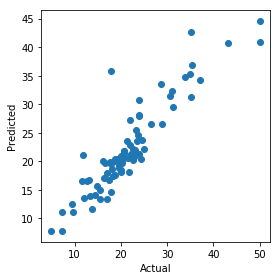

In [627]:
# We can plot the actuals and the predicted values 
plt.figure(figsize=(4, 4))
plt.scatter(Y_test, predictedvalues)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.tight_layout()